In [3]:
""""
Imports packages
"""
import tellurium as te
import pickle 
import math
import csv
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import ParameterSampler
from scipy.stats import lognorm
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import pandas as pd

KeyboardInterrupt: 

In [ ]:
"""
Opens model, reads the file, and extracts the ground truth values for each species id
"""

model = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")
r = te.loada(model)

values = r.getSteadyStateValues()
species_ids = r.getFloatingSpeciesIds()

if len(values) != len(species_ids):
    print("values and species don't match")
else:
    for species_id, val in zip(species_ids, values): 
        if val < 0:
            print(f"negative concentrations")
        r[species_id] = val
    
    try:
        ground_truth = r.getScaledFluxControlCoefficientMatrix()
        
        with open('ground_truth.pkl', 'wb') as file: 
            pickle.dump(ground_truth, file)
    except RuntimeError as e:
        print(f"Error: {e}")


In [ ]:
"""
Extracts parameter names, removes equilibrium constants
"""

param_names = r.getGlobalParameterIds()
param_names = [param for param in param_names if 'Keq' not in param and 'e_' not in param] #remove e_vPGI
print(param_names)

['PGI_Vmax', 'PGI_KmG6P', 'PGI_KmF6P', 'PGI_KmPEP', 'PGI_KmPGN', 'PFK_Vmax', 'PFK_n', 'KdATPMg', 'KdADPMg', 'PFK_KirF6P', 'PFK_KmrATPMg', 'PFK_KmrFDP', 'PFK_KirFDP', 'PFK_KmrADP', 'PFK_KmrF6P', 'PFK_KirADP', 'PFK_KirATP', 'PFK_Wr', 'PFK_L0', 'PFK_KmtFDP', 'PFK_KitFDP', 'PFK_KmtADP', 'PFK_KmtF6P', 'PFK_KitF6P', 'PFK_KmtATPMg', 'PFK_KitADP', 'PFK_KitATP', 'PFK_Wt', 'PFK_KeftADP', 'PFK_KeftPEP', 'PFK_KefrADP', 'PFK_KefrPEP', 'FBA_Vmax', 'FBA_KmFDP', 'FBA_KmDAP', 'FBA_KmGAP', 'FBA_KmPEP', 'TPI_Vmax', 'TPI_KmDAP', 'TPI_KmGAP', 'GDH_Vmax', 'GDH_KmP', 'GDH_KmGAP', 'GDH_KmNAD', 'GDH_KmBPG', 'GDH_KmNADH', 'PGK_Vmax', 'PGK_KmADPMg', 'PGK_KmBPG', 'PGK_KmATPMg', 'PGK_KmPGA3', 'GPM_Vmax', 'GPM_KmPGA3', 'GPM_KmPGA2', 'ENO_Vmax', 'ENO_KmPGA2', 'ENO_KmPEP', 'PYK_Vmax', 'PYK_n', 'PYK_KirPEP', 'PYK_KmrADPMg', 'PYK_KmrPEP', 'PYK_KirATP', 'PYK_KirADP', 'PYK_KirPYR', 'PYK_KirPyrATP', 'PYK_L0', 'PYK_KmtPEP', 'PYK_KitPEP', 'PYK_KmtADPMg', 'PYK_KitATP', 'PYK_KitADP', 'PYK_KitPYR', 'PYK_KitPyrATP', 'PYK_KeftSU

In [ ]:
"""
Saves the highest working value for the first n number of parameters and extracts the control coefficients for each value that works
"""


model = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")
r = te.loada(model)

param_names = param_names[:1]
plot_data = {}

for param in param_names:
    ranges_that_work = {}
    in_val = r[param]
    
    for j in range(1, 10):
        scale_factor = math.log(j + 1)  
        val = min(in_val * scale_factor, 1000)
        
        if val == 1000:
            break
        
        r[param] = val
        
        try:
            flux_control_coefficients = r.getScaledFluxControlCoefficientMatrix()
            ranges_that_work[val] = flux_control_coefficients
        except RuntimeError as e:
            print(f"Error: {e}")
            print(f"Param '{param}' failed for value {val}")
        
    if ranges_that_work:
        highest_working_value = max(ranges_that_work.keys())
        plot_data[param] = {highest_working_value, in_val}
        
        with open(f'{param}_test.pkl', 'wb') as file: 
            pickle.dump(ranges_that_work, file)
    else:
        print(f"All values failed for parameter {param}")
    
    print("\n\n\n\n")
    print(f"Acceptable range of values for parameter {param}:")
    print(ranges_that_work)
    
    r[param] = in_val
    
with open('parameters_that_work.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['Parameter', 'Parameter Value', 'Flux Control Coefficients'])
    writer.writeheader()
    
    for param in param_names:
        with open(f'{param}_test.pkl', 'rb') as file:
            ranges = pickle.load(file)
        
        for val, flux_control in ranges.items():
            flux_control_str = str(flux_control)  
            writer.writerow({'Parameter': param, 'Parameter Value': val, 'Flux Control Coefficients': flux_control_str})


In [ ]:
"""
Graphs the highest working value for each parameter
"""


import matplotlib.pyplot as plt
import numpy as np

initial_values = []
highest_working_values = []
params_to_plot = []  

for param in plot_data:
    highest_working_value, in_val = plot_data[param]
    
    initial_values.append(in_val)
    
    highest_working_values.append(highest_working_value)
    params_to_plot.append(param)

initial_values = np.array(initial_values)
highest_working_values = np.array(highest_working_values)

plt.figure(figsize=(8, 6))

for i, param in enumerate(params_to_plot):
    if 'Vmax' in param:
        color = 'blue'
    elif 'Km' in param:
        color = 'red'
    elif 'PGI' in param:
        color = 'purple'
    elif 'PYK' in param:
        color = 'black'
    else:
        color = 'gray' 
    
    plt.scatter(initial_values[i], highest_working_values[i], color=color, marker='o')
    plt.annotate(param, (initial_values[i], highest_working_values[i]))

    #plt.xlim(0, 0.5)
    #plt.ylim(0, 2)
    
plt.title('Initial vs Highest Working Value')
plt.xlabel('Initial Parameter Value')
plt.ylabel('Highest Working Parameter Value')
plt.grid(True)

plt.legend()

plt.show()


In [ ]:
"""
Grid parameter search for the TopologyC_1.ant model (can adjust number of parameters to do search over)

"""


model_text = te.readFromFile("C:/Users/bhavy/OneDrive/Desktop/SauroLab_2025/modeling/TopologyC_1.ant")

names = ['PGI_Vmax', 'PGI_KmG6P', 'PGI_KmF6P']

params_that_worked = []
params_that_failed = []

def run_and_save_grid_search(param_set): 
    print(f"Trying: {param_set}")
    
    for param, value in param_set.items():
        if param in r.getGlobalParameterIds(): 
            r[param] = value 
            print(f"{param}: {value}")
        else: 
            print(f"{param} not found")
 
    try:
        fcc = r.getScaledFluxControlCoefficientMatrix()

        if (
            np.isnan(fcc).any()
            or np.isinf(fcc).any()
            or not np.all(np.isfinite(fcc))
            or np.abs(fcc).max() < 1e-6   # suspiciously small everywhere
            or np.abs(fcc).max() > 1e3    # unreasonably large values
            or np.allclose(fcc, 0, atol=1e-5)  # entirely zero or negligible
        ):
            params_that_failed.append(param_set.copy())
            print("failed")
        else: 
            params_that_worked.append(param_set.copy())
    except RuntimeError as e:
        print(f"Error: {e}")
        print(f"Failed param set: {param_set}")
        params_that_failed.append(param_set.copy())

param_dists = {name: lognorm(s=0.5, scale=np.exp(2)) for name in names}

n_samples = 50
grid = list(ParameterSampler(param_dists, n_iter=n_samples, random_state=42))

for param_set in grid:
    run_and_save_grid_search(param_set)

print(f"successful parameter sets: {len(params_that_worked)}")
print(params_that_worked)

In [ ]:
"""
Visualization of parameter search
"""

x='PGI_Vmax'
y='PGI_KmF6P'
z='PGI_KmG6P'
r = te.loada(model_text)

x_vals, y_vals, z_vals = [], [], []

for p in params_that_worked:
    x_vals.append(p[x] - r[x])
    y_vals.append(p[y] - r[y])
    z_vals.append(p[z] - r[z])

x_vals_failed, y_vals_failed, z_vals_failed = [], [], []

for p in params_that_failed: 
    x_vals_failed.append(p[x] - r[x])
    y_vals_failed.append(p[y] - r[y])
    z_vals_failed.append(p[z] - r[z])


fig = plt.figure(figsize=(8, 24))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_vals, y_vals, z_vals, 0.1, 0.1, 0.1, color='blue', alpha=0.8) 
#ax.bar3d(x_vals_failed, y_vals_failed, z_vals_failed, 0.1, 0.1, 0.1, color='red', alpha=0.8) 

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
ax.set_title('Parameter Combinations')

plt.tight_layout()
plt.show()


"""
Successful parameter combinations will show up as blue points. 
Unsuccessful parameter combinations will show up as red points.
The x,y,z axes are the differences from the standard value for each parameter.  

x='PGI_Vmax'
y='PGI_KmF6P'
z='PGI_KmG6P'
"""

In [ ]:
"""
Testing different correlation between parameters that work
Tested following correlation: 
1. Pearson correlation coefficient (linear relationship)
- Determine if there is any correlation between each of the variables pairwise
2. Test if there is a polynomial relationship pairwise between the variables next
- Try different polynomial degrees and take max r-squared from those
Not strong correlation linearly 
"""
#Data Extraction
x = 'PGI_Vmax'
param1 = np.array([p[x] for p in params_that_worked])

y = 'PGI_KmF6P'
param2 = np.array([p[y] for p in params_that_worked])

z = 'PGI_KmG6P'
param3 = np.array([p[z] for p in params_that_worked])

data = pd.DataFrame({
    'x': param1,
    'y': param2,
    'z': param3
})

correlation_matrix = data.corr()
print(correlation_matrix)

#not a linear relationship, will try polynomial relationship next

Experiments for Janis: 
1. Explore points around a working point 
2. Get and store histogram of flux control coefficients with distribution of parameter values (historgram of both)
3. store all working values 
4. Create an nD plot 
5. Do dimensionality reduction to 3D
6. Try to fit a polynomial surface through it 

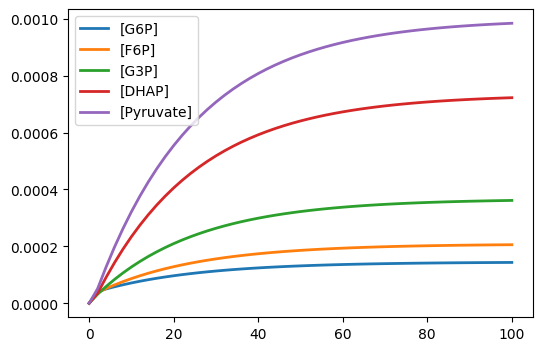

          J1,           J2,           J3,           J4, J5,         J6
J1 [[ 0.9998,            0,            0,  3.55129e-20,  0, 0.00019988],
J2  [ 0.9998, -2.22045e-16, -1.11022e-16, -2.22045e-16,  0, 0.00019988],
J3  [ 0.9998,            0,            0, -6.66134e-16, -0, 0.00019988],
J4  [ 0.9998,            0,            0,  1.11022e-15,  0, 0.00019988],
J5  [      0,            0,            0,            0,  0,          0],
J6  [ 0.9998,            0,            0, -1.77636e-16,  0, 0.00019988]]

In [2]:
import tellurium as te
ant_str = """
model toy_metabolism_steady_state

  // Species
  species $Glucose, G6P, F6P, G3P, DHAP, Pyruvate

  // Reactions
  J1: -> G6P; (k1 * Glucose) / (1 + Pyruvate / Ki)
  J2: G6P -> F6P; (V2f * G6P / K2s - V2r * F6P / K2p) / (1 + G6P / K2s + F6P / K2p)
  J3: F6P -> G3P; (V3f * F6P / K3s - V3r * G3P / K3p) / (1 + F6P / K3s + G3P / K3p)
  J4: G3P -> Pyruvate; (V4f * G3P / K4s - V4r * Pyruvate / K4p) / (1 + G3P / K4s + Pyruvate / K4p)
  J5: G3P -> DHAP; (V5f * G3P / K5s - V5r * DHAP / K5p) / (1 + G3P / K5s + DHAP / K5p)
  J6: Pyruvate -> ; k_drain * Pyruvate  // drain reaction to maintain flow

  // Initial concentrations
  Glucose = 10
  G6P = 0
  F6P = 0
  G3P = 0
  DHAP = 0
  Pyruvate = 0

  // Parameters
  k1 = 1e-5
  Ki = 5

  V2f = 0.5; V2r = 0.3; K2s = 0.1; K2p = 0.1
  V3f = 0.4; V3r = 0.2; K3s = 0.1; K3p = 0.1
  V4f = 0.3; V4r = 0.1; K4s = 0.1; K4p = 0.1
  V5f = 0.2; V5r = 0.1; K5s = 0.1; K5p = 0.1

  k_drain = 0.1  // removal rate of Pyruvate

end

"""
r = te.loada(ant_str)
r.simulate(0,100)
r.plot()
r.steadyState()
r.getScaledFluxControlCoefficientMatrix()

In [ ]:
import random
import numpy as np 
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import os
import json

step_size = 0.5
total_explores = 500

def randomly_perturb(params, step_size):
    new_params = copy.deepcopy(params)
    for key in new_params:
        scale = 1 + random.uniform(-step_size, step_size)
        new_params[key] *= scale
    return new_params


def valid(params): 
    for param in params: 
        r[param] = params[param] 
    try: 
        _ = r.getScaledFluxControlCoefficientMatrix()
        return True
    except RuntimeError: 
        return False
    
base_folder = "steps" 
os.makedirs(base_folder, exist_ok=True)

def generate_histogram(current_params, step_number): 
    folder = os.path.join(base_folder, f"step_{step_number}")
    os.makedirs(folder, exist_ok=True)

    fcc_matrix = r.getScaledFluxControlCoefficientMatrix()
    fcc_values = fcc_matrix.flatten()
    fcc_values = fcc_values[np.abs(fcc_values) > 1e-6]

    plot_fcc_heatmap(fcc_matrix, step_number, folder)

    plt.figure(figsize=(8, 5))
    plt.hist(fcc_values, bins=20, edgecolor='black', color='skyblue')
    plt.title(f"Histogram of Flux Control Coefficients\nStep {step_number}")
    plt.xlabel("FCC value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(folder, "fcc_histogram.png"), dpi=300, bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(10, 5))
    keys = list(current_params.keys())
    values = [current_params[k] for k in keys]
    plt.bar(keys, values, color='lightcoral')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Parameter Value")
    plt.title(f"Parameter Values at Step {step_number}")
    plt.tight_layout()
    plt.savefig(os.path.join(folder, "parameter_barchart.png"), dpi=300, bbox_inches='tight')
    plt.close()

    json_path = os.path.join(folder, "params.json")
    with open(json_path, "w") as f:
        json.dump(current_params, f, indent=2)

def plot_fcc_heatmap(fcc_matrix, step_number, folder):
    plt.figure(figsize=(8, 6))
    sns.heatmap(fcc_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"FCC Matrix Heatmap - Step {step_number}")
    plt.xlabel("Reaction")
    plt.ylabel("Control Parameter")
    plt.tight_layout()
    plt.savefig(os.path.join(folder, "fcc_heatmap.png"), dpi=300)
    plt.close()

params = r.model.getGlobalParameterIds()

starting_set = {param: r[param] for param in params}
current = copy.deepcopy(starting_set)
history = [copy.deepcopy(current)]

max_tries = 10
for step in range(1, total_explores + 1):
    curr_tries = 0
    found_valid = False

    while curr_tries < max_tries and not found_valid:
        candidate = randomly_perturb(current, step_size)
        if valid(candidate):
            current = copy.deepcopy(candidate)
            history.append(current)
            generate_histogram(current, step)
            found_valid = True
        else:
            curr_tries += 1

    if not found_valid:
        print(f"Maxed out")

284
Explained variance ratio by each PCA component: [0.67936613 0.15641437 0.10576387]


Text(0.5, 0.92, 'PCA of Valid Parameter Sets (3D)')

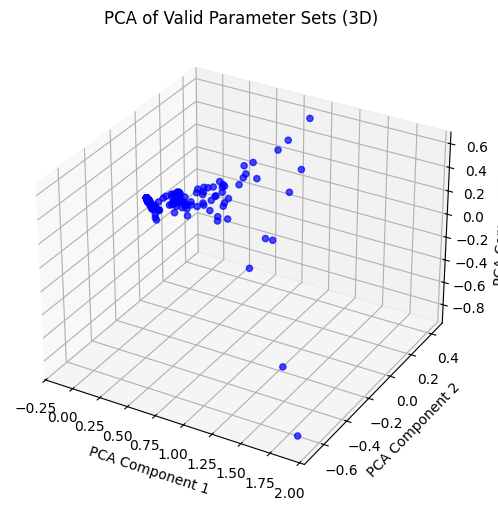

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(len(history))
param_names = list(history[0].keys())
data_matrix = np.array([[params[name] for name in param_names] for params in history])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_matrix)

print(f"Explained variance ratio by each PCA component: {pca.explained_variance_ratio_}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:,0], pca_result[:,1], pca_result[:,2], c='blue', alpha=0.7)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("PCA of Valid Parameter Sets (3D)")


In [10]:
pca = PCA(n_components=3)
pca.fit(data_matrix)

loadings = pca.components_

first_pc_loadings = loadings[0] 

param_contributions = list(zip(param_names, first_pc_loadings))

param_contributions_sorted = sorted(param_contributions, key=lambda x: abs(x[1]), reverse=True)

for param, loading in param_contributions_sorted:
    print(f"{param}: {loading:.4f}")


V4f: 0.5440
Ki: 0.5417
V5f: 0.4221
K3s: 0.3165
K5p: 0.2118
k_drain: 0.2053
K3p: 0.1313
K4p: 0.1161
K2p: 0.0752
V5r: 0.0625
K5s: 0.0596
V3f: 0.0284
K2s: 0.0195
V2f: 0.0112
V3r: 0.0108
V4r: 0.0067
V2r: 0.0049
K4s: 0.0014
k1: 0.0000
